# Adaptive Learning and Design

## Prediction Improvement with Multiple Cycles

Start by importing some modules, data from the paper, and writing some helper functions:

In [2]:
import gains as genetic
from gains import adaptive as ald
import salty
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from rdkit.Chem import Draw
from rdkit import Chem
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('../data/adaptive_learn_results.csv')

from numpy import array
from keras.models import load_model
from os.path import dirname, join
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.six import iteritems
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from matplotlib.pyplot import figure
from rdkit.Chem.Draw.canvasbase import CanvasBase
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)
from scipy.constants import golden as phi

def raad(y_true, y_pred):
    return np.sum(np.abs((y_pred-y_true)/y_true))/len(y_true)*100

class Canvas(CanvasBase):

  def __init__(self, size, name='', imageType='png'):
    self._name = name
    self.size = size
    dpi = max(size[0], size[1])
    figsize = (int(float(size[0]) / dpi), int(float(size[1]) / dpi))
    self._figure = figure(figsize=figsize)
    self._axes = self._figure.add_axes([0, 0, 2.5, 2.5])
    self._axes.set_xticklabels('')
    self._axes.set_yticklabels('')
    self._axes.get_xaxis().set_visible(False)
    self._axes.get_yaxis().set_visible(False)
    self._dpi = dpi

  def rescalePt(self, p1):
    return [float(p1[0]) / self._dpi, float(self.size[1] - p1[1]) / self._dpi]

  def addCanvasLine(self, p1, p2, color=(0, 0, 0), color2=None, **kwargs):
    canvas = self._axes
    p1 = self.rescalePt(p1)
    p2 = self.rescalePt(p2)
    if color2 and color2 != color:
      mp = (p1[0] + p2[0]) / 2., (p1[1] + p2[1]) / 2.
      canvas.add_line(Line2D((p1[0], mp[0]), (p1[1], mp[1]), color=color, **kwargs))
      canvas.add_line(Line2D((mp[0], p2[0]), (mp[1], p2[1]), color=color2, **kwargs))
    else:
      canvas.add_line(Line2D((p1[0], p2[0]), (p1[1], p2[1]), color=color, **kwargs))
    
  def addCanvasPolygon(self, ps, color=(0, 0, 0), **kwargs):
    canvas = self._axes
    ps = [self.rescalePt(x) for x in ps]
    canvas.add_patch(Polygon(ps, linewidth=0, facecolor=color))
  def addCanvasText(self, text, pos, font, color=(0, 0, 0), **kwargs):
    import re
    pos = self.rescalePt(pos)
    canvas = self._axes
    text = re.sub(r'<.*?>', '', text)
    orientation = kwargs.get('orientation', 'E')
    halign = 'center'
    valign = 'center'
    if orientation == 'E':
      halign = 'left'
    elif orientation == 'W':
      halign = 'right'
    elif orientation == 'S':
      valign = 'top'
    elif orientation == 'N':
      valign = 'bottom'

    annot = canvas.annotate(text, (pos[0], pos[1]), color=color, verticalalignment=valign,
                            horizontalalignment=halign, weight=font.weight, size=font.size * 2.0,
                            family=font.face)

    try:
      bb = annot.get_window_extent(renderer=self._figure.canvas.get_renderer())
      w, h = bb.width, bb.height
      tw, th = canvas.transData.inverted().transform((w, h))
    except AttributeError:
      tw, th = 0.1, 0.1  # <- kludge
    return (tw, th, 0)

  def addCanvasPolygon(self, ps, color=(0, 0, 0), **kwargs):
    canvas = self._axes
    ps = [self.rescalePt(x) for x in ps]
    canvas.add_patch(Polygon(ps, linewidth=0, facecolor=color))

def draw(smiles, size=(300, 300), kekulize=True, wedgeBonds=True, imageType=None, fitImage=False, options=None, **kwargs):
    """
    draw smiles to notebook with RDKit
    
    and without those dumb matplotlib ticks
    
    ¯\_(ツ)_/¯
    
    """
    canvas = Canvas(size)
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.Mol(mol.ToBinary())
    Chem.Kekulize(mol)
    AllChem.Compute2DCoords(mol)
    drawer = MolDrawing(canvas=canvas)
    omol = mol
    drawer.AddMol(mol)
    omol._atomPs = drawer.atomPs[mol]
    for k, v in iteritems(omol._atomPs):
        omol._atomPs[k] = canvas.rescalePt(v)
    canvas._figure.set_size_inches(float(size[0]) / 100, float(size[1]) / 100)
    canvas._figure
    return canvas._figure

def load_salty_models(model_ID, path=None):
    """
    loads models from adaptive learning cycles or the salty library
    """
    for i, name in enumerate(model_ID):
        if path:
            model = np.array([load_model(join(path,
                                              '{}_qspr.h5'.format(name)))])
            with open(join(path, '{}_desc.csv'.format(name)),
                      'rb') as csv_file:
                deslist = list([pd.read_csv(csv_file, encoding='latin1')])
            with open(join(path, '{}_summ.csv'.format(name)),
                      'rb') as csv_file:
                summary = pd.read_csv(csv_file, encoding='latin1')
        else:
            model = np.array([genetic.load_data("{}_qspr.h5".format(name),
                                                h5File=True)])
            deslist = list([genetic.load_data("{}_desc.csv".format(name))])
            summary = genetic.load_data("{}_summ.csv".format(name))
        parents = eval(summary.iloc[1][1])
        anions = eval(summary.iloc[2][1])
        if i > 0:
            parent_candidates = np.concatenate((parents, parent_candidates))
            anion_candidates = np.concatenate((anions, anion_candidates))
            models = np.concatenate((models, model))
            deslists = list([deslists, deslist])
            summaries = list([summaries, summary])
        else:
            parent_candidates = parents
            anion_candidates = anions
            models = model
            deslists = deslist
            summaries = summary
    return parent_candidates, anion_candidates, models, deslists, summaries

We can start by reproducing Fig. 2 in the manuscript:

In [2]:
cpt_dens_errors = np.zeros((2,4))
for i in range(1,5):
    dff = df.loc[df['Series'] == 1]
    dff = dff.loc[dff['Round'] == i]
    cpt_dens_errors[0,i-1] = np.average(dff['% error, cpt'])
    cpt_dens_errors[1,i-1] = np.average(dff['% error, density'])

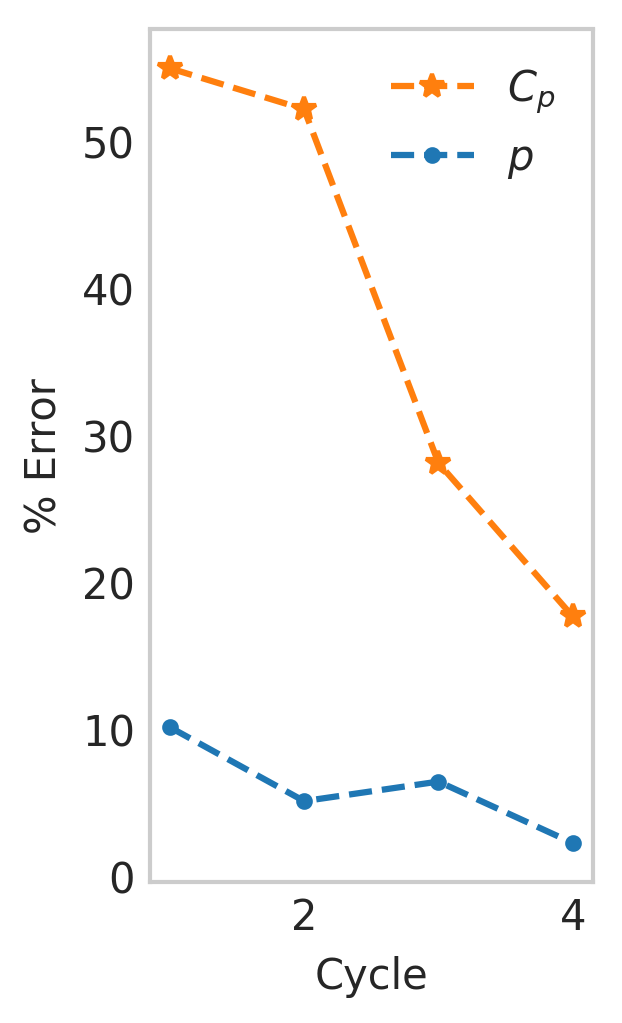

In [3]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(3.5/phi,3.5), dpi=300)
    ax=fig.add_subplot(111)
    ax.plot(np.arange(1,5), cpt_dens_errors[0], 'k--', marker='*', label='$C_p$', c='tab:orange')
    ax.plot(np.arange(1,5), cpt_dens_errors[1], 'k--', marker='.', label='$p$', c='tab:blue')
    plt.grid()
    plt.legend()
    plt.xlabel('Cycle')
    plt.ylabel('% Error')
    plt.tick_params(direction='in')
    plt.tight_layout()

In [4]:
#set axis limits for all subplots
dff = df.loc[(df['Series'] == 1)]
minval = np.min([dff['predicted cpt'],dff['calculated cpt'],
                     dff['predicted density'],dff['calculated density']])
maxval = np.max([dff['predicted cpt'],dff['calculated cpt'],
                     dff['predicted density'],dff['calculated density']])
buffer = (maxval - minval) / 100 * 2
minval = minval - buffer
maxval = maxval + buffer

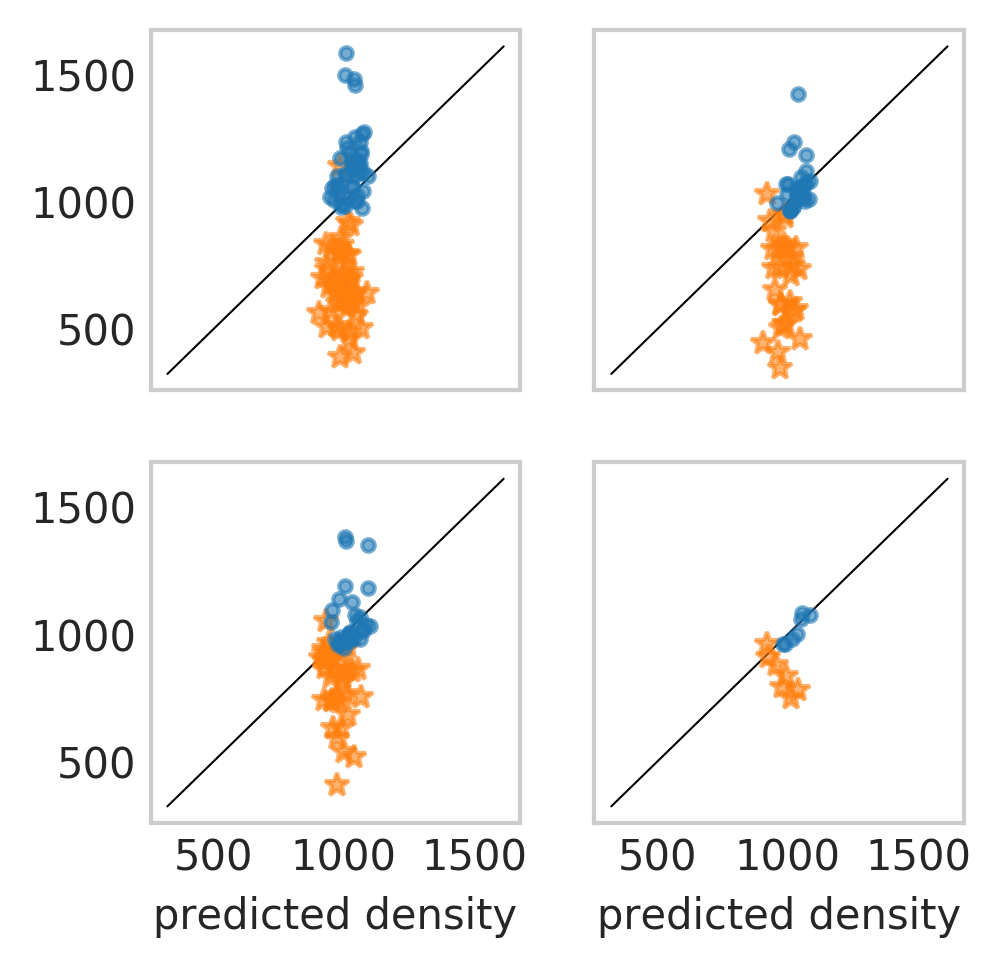

In [5]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(3.5,3.5), dpi=300)    
    ax1=fig.add_subplot(221)
    ax2=fig.add_subplot(222)   
    ax3=fig.add_subplot(223)
    ax4=fig.add_subplot(224)

    ax1.plot([minval, maxval], [minval, maxval], linestyle="-",
            label=None, c="black", linewidth=.5)   
    dff = df.loc[(df['Series'] == 1) & (df['Round'] == 1)]
    dff.plot(x='predicted cpt', y='calculated cpt', style='*',
             ax=ax1, color='tab:orange', grid=False, alpha=0.6,
             legend=False, sharex=True)
    dff.plot(x='predicted density', y='calculated density', style='.',
             ax=ax1, color='tab:blue', grid=False, alpha=0.6,
             legend=False)

    ax2.plot([minval, maxval], [minval, maxval], linestyle="-",
            label=None, c="black", linewidth=.5)   
    dff = df.loc[(df['Series'] == 1) & (df['Round'] == 2)]
    dff.plot(x='predicted cpt', y='calculated cpt', style='*',
             ax=ax2, color='tab:orange', grid=False, alpha=0.6,
             legend=False, sharey=True)
    dff.plot(x='predicted density', y='calculated density', style='.',
             ax=ax2, color='tab:blue', grid=False, alpha=0.6,
             legend=False)
    
    ax3.plot([minval, maxval], [minval, maxval], linestyle="-",
            label=None, c="black", linewidth=.5)   
    dff = df.loc[(df['Series'] == 1) & (df['Round'] == 3)]
    dff.plot(x='predicted cpt', y='calculated cpt', style='*',
             ax=ax3, color='tab:orange', grid=False, alpha=0.6,
             legend=False, sharey=True)
    dff.plot(x='predicted density', y='calculated density', style='.',
             ax=ax3, color='tab:blue', grid=False, alpha=0.6,
             legend=False)
    
    ax4.plot([minval, maxval], [minval, maxval], linestyle="-",
            label=None, c="black", linewidth=.5)   
    dff = df.loc[(df['Series'] == 1) & (df['Round'] == 4)]
    dff.plot(x='predicted cpt', y='calculated cpt', style='*',
             ax=ax4, color='tab:orange', grid=False, alpha=0.6,
             legend=False, sharey=True)
    dff.plot(x='predicted density', y='calculated density', style='.',
             ax=ax4, color='tab:blue', grid=False, alpha=0.6,
             legend=False)

In [6]:
#For creating images in iPython

# IPythonConsole.ipython_useSVG=True
# dff = df.loc[(df['Series'] == 1) & (df['Round'] == 4)]
# dff.reset_index(inplace=True)
# ms = [Chem.MolFromSmiles(y) for y in dff['Salt Smiles']]
# labels = ['{}  {}'.format(str(x), str(y)) for x,y in dff[['% error, cpt', '% error, density']].values]
# fig = Draw.MolsToGridImage(ms,legends=labels,molsPerRow=2)
# fig

And the corresponding IL images:

     % error, cpt  % error, density          Anion
383         35.08              0.84    L-prolinate
384         23.23              3.51    L-prolinate
385         19.04              0.68     L-lysinate
386          1.10              2.02  octyl sulfate
387          4.34              2.96  octyl sulfate
388         32.54              2.71  octyl sulfate
389          8.69              3.43  octyl sulfate


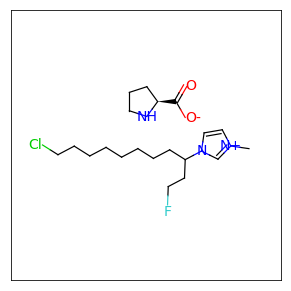

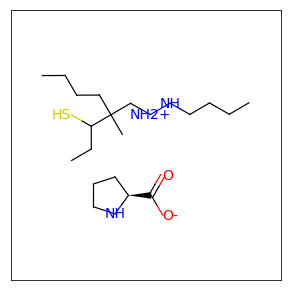

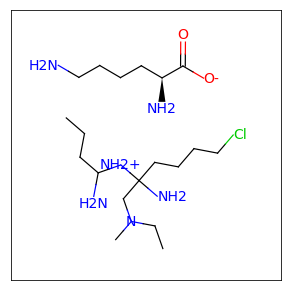

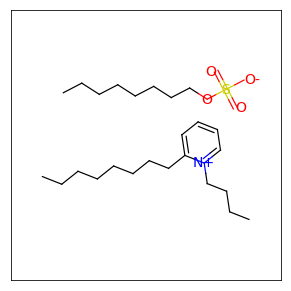

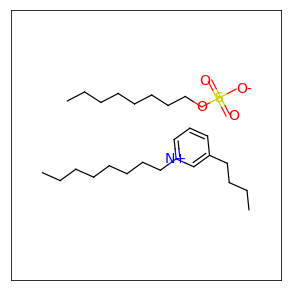

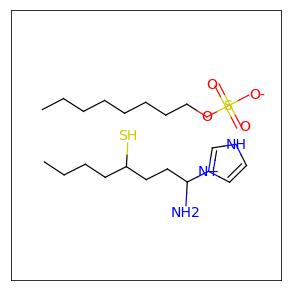

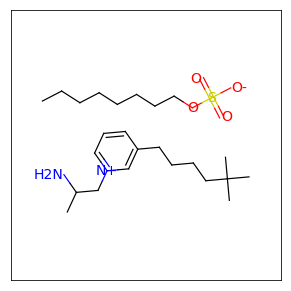

In [7]:
dff = df.loc[(df['Series'] == 1) & (df['Round'] == 4)]
print(dff[['% error, cpt', '% error, density', 'Anion']])
for i in dff['Salt Smiles']:
    draw(i, size=(150,150))

In [14]:
#To save images

for i in dff['Salt Smiles']:
    img = draw(i, size=(150,150))
#     img.savefig(fname="assets/{}.svg".format(i), 
#                 bbox_inches='tight', format='svg', transparent=True) 
    img.clf()

<Figure size 108x108 with 0 Axes>

<Figure size 108x108 with 0 Axes>

<Figure size 108x108 with 0 Axes>

<Figure size 108x108 with 0 Axes>

<Figure size 108x108 with 0 Axes>

<Figure size 108x108 with 0 Axes>

<Figure size 108x108 with 0 Axes>

We've shown that our predictions improve for ILs created by the genetic algorithm. What can be said about the new models' performances on predicting properties for the experimental data?

In [279]:
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
data_range = [[206, 2295]] #the cpt dataset has one outlier ~9,000 J/mol/K
adl_models = [['density_1', 'cpt_1'],['density_2', 'cpt_2'],['density_3', 'cpt_3'],['density_4', 'cpt_4']]
props = [['density'],['cpt']]
for i, prop in enumerate(props):
    devmodel = salty.aggregate_data(prop, T=T, P=P, data_ranges=data_range)
    X_train, Y_train, X_test, Y_test = salty.devmodel_to_array\
        (devmodel, train_fraction=1)
    for model_name in adl_models:
        parent_candidates, anion_candidates, models, deslists, summaries = load_salty_models(model_name, path='../data/adl_models')
        train_scores = models[i].evaluate(X_train, Y_train)
        print("%s: %.2f%% for all %s experimental data" % (models[i].metrics_names[1], train_scores[1]*100, prop[0]))        
        print('RAAD for all {} experimental data: {:.2f}'.format(prop[0], raad(np.exp(Y_train), np.exp(models[i].predict(X_train)))))

5631/5631 [==============================] - 2s 326us/step
mean_squared_error: 0.02% for all density experimental data
RAAD for all density experimental data: 0.70
5631/5631 [==============================] - 2s 342us/step
mean_squared_error: 0.01% for all density experimental data
RAAD for all density experimental data: 0.68
5631/5631 [==============================] - 2s 354us/step
mean_squared_error: 0.03% for all density experimental data
RAAD for all density experimental data: 1.11
5631/5631 [==============================] - 2s 356us/step
mean_squared_error: 0.02% for all density experimental data
RAAD for all density experimental data: 0.84
1734/1734 [==============================] - 2s 1ms/step
mean_squared_error: 1.10% for all cpt experimental data
RAAD for all cpt experimental data: 4.93
1734/1734 [==============================] - 2s 1ms/step
mean_squared_error: 0.96% for all cpt experimental data
RAAD for all cpt experimental data: 5.32
1734/1734 [=========================

Some improvement in error rates. Let's try this with a completely unseen-by-the-model validation set from the experimental data

In [ ]:
#load exp data, split into trian/validation, append round data, train model, predict on validation set.

In [4]:
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator
from sklearn.preprocessing import StandardScaler
from numpy import log
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping

In [280]:
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
data_range = [[206, 2295]] #the cpt dataset has one outlier ~9,000 J/mol/K
adl_models = [['density_1', 'cpt_1'],['density_2', 'cpt_2'],['density_3', 'cpt_3'],['density_4', 'cpt_4']]
props = [['density'],['cpt']]
devmodel = salty.aggregate_data(props[0], T=T, P=P, data_ranges=data_range)
parent_candidates, anion_candidates, models, deslists, summaries = load_salty_models(adl_models[0], path='../data/adl_models')
devmodel = salty.aggregate_data(props[0], T=T, P=P, data_ranges=data_range)
deslist = deslists[0]
if isinstance(deslist, list):
    deslist = deslist[0]
devmodel.Data.iloc[:,:190] = devmodel.Data.iloc[:,:190] * deslist.iloc[1].values + deslist.iloc[0].values
devmodel.Data = devmodel.Data.sample(frac=1)

for j in range(1,5,1):
    df = pd.read_csv('../data/adaptive_learn_results.csv')
    df2 = df.loc[(df['Series'] == 1) & (df['Round'] <= j)]
    df2.reset_index(inplace=True, drop=True)

    for k in range(df2.shape[0]):
        cation_smiles = df2['Salt Smiles'][k].split(".")[0]
        anion_smiles = df2['Salt Smiles'][k].split(".")[1]
        anion = Chem.MolFromSmiles(anion_smiles)
        cation = Chem.MolFromSmiles(cation_smiles)

        predictions = []
        for i, name in enumerate(models[:1]):
            model = name
            deslist = deslists[i]
            if isinstance(deslist, list):
                deslist = deslist[0]
            feature_vector = []

            for item in deslist:

                if "anion" in item:
                    with genetic.suppress_rdkit_sanity():
                        feature_vector.append(calculator([item.partition('-')
                                              [0]]).CalcDescriptors(anion)[0])
                elif "cation" in item:
                    with genetic.suppress_rdkit_sanity():
                        feature_vector.append(calculator([item.partition('-')
                                              [0]]).CalcDescriptors(cation)[0])
                elif "Temperature, K" in item:
                    feature_vector.append(298.15)
                elif "Pressure, kPa" in item:
                    feature_vector.append(101.325)
                else:
                    print("unknown descriptor in list: %s" % item)
            feature_vector.append(df2['calculated density'][k]) 
            feature_vector.append('name-anion')
            feature_vector.append(anion_smiles)
            feature_vector.append('name-cation')
            feature_vector.append(cation_smiles)
            if k == 0:
                adl_data = pd.DataFrame([feature_vector], columns=devmodel.Data.columns)
            else:
                new = pd.DataFrame([feature_vector], columns=devmodel.Data.columns)
                adl_data = pd.concat([adl_data, new])
    combined = pd.concat([adl_data, devmodel.Data])    
    data = ['density']
    instance = StandardScaler()

    rawdf = combined
    metaDf = rawdf.select_dtypes(include=["object"])
    dataDf = rawdf.select_dtypes(include=[np.number])
    metaDf = metaDf.reset_index(drop=True)
    dataDf = dataDf.reset_index(drop=True)
    for i in range(1, len(data) + 1):
        dataDf.is_copy = False
        dataDf.iloc[:, -i] = dataDf.iloc[:, -i].apply(lambda x:
                                                      log(float(x)))
    scaled_data = pd.DataFrame(instance.
                               fit_transform(dataDf.iloc[:, :-len(data)]),
                               columns=dataDf.columns[:-len(data)])
    df = pd.concat([scaled_data, dataDf.iloc[:, -len(data):], metaDf],
                   axis=1)
    mean_std_of_coeffs = pd.DataFrame([instance.mean_, instance.scale_],
                                      columns=dataDf.columns[:-len(data)])
    rawdf = df
    test_fraction = 0.8 #test fraction of exp data
    model_outputs = 1
    datadf = rawdf.select_dtypes(include=[np.number])

    data = np.array(datadf)

    n = devmodel.Data.shape[0] 
    d = data.shape[1]
    d -= model_outputs
    n_test = int(n * test_fraction)  # set fraction for training
    n_train = data.shape[0] - n_test

    X_train = np.zeros((n_train, d))  # prepare train/test arrays
    X_test = np.zeros((n_test, d))
    Y_train = np.zeros((n_train, model_outputs))
    Y_test = np.zeros((n_test, model_outputs))
    X_train[:] = data[:n_train, :-model_outputs]
    Y_train[:] = (data[:n_train, -model_outputs:].astype(float))
    X_test[:] = data[n_train:, :-model_outputs]
    Y_test[:] = (data[n_train:, -model_outputs:].astype(float))

    early = EarlyStopping(monitor='mean_squared_error', patience=50, verbose=1)
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer="adam",
                  loss="mean_squared_error",
                  metrics=['mse'])
    model.fit(X_train,Y_train,epochs=10000,verbose=False,callbacks=[early])
    test_scores = model.evaluate(X_test, Y_test) 
    train_scores = model.evaluate(X_train, Y_train)
    print("%s: %.2f%% for train data" % (model.metrics_names[1], train_scores[1]*100))
    print("%s: %.2f%% for test data" % (model.metrics_names[1], test_scores[1]*100))
    print('RAAD: {:.2f} for train data'.format(raad(np.exp(Y_train), np.exp(model.predict(X_train)))))
    print('RAAD: {:.2f} for test data'.format(raad(np.exp(Y_test), np.exp(model.predict(X_test)))))

Epoch 00395: early stopping
1174/1174 [==============================] - 0s 102us/step
mean_squared_error: 0.74% for train data
mean_squared_error: 0.03% for test data
RAAD: 1.58 for train data
RAAD: 0.52 for test data
Epoch 00244: early stopping
1204/1204 [==============================] - 0s 110us/step
mean_squared_error: 3.51% for train data
mean_squared_error: 0.15% for test data
RAAD: 8.03 for train data
RAAD: 1.69 for test data
Epoch 00220: early stopping
1238/1238 [==============================] - 0s 109us/step
mean_squared_error: 1.71% for train data
mean_squared_error: 0.09% for test data
RAAD: 4.17 for train data
RAAD: 1.65 for test data
Epoch 00229: early stopping
1245/1245 [==============================] - 0s 113us/step
mean_squared_error: 0.60% for train data
mean_squared_error: 0.16% for test data
RAAD: 2.81 for train data
RAAD: 1.44 for test data


In [11]:
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
data_range = [[206, 2295]] #the cpt dataset has one outlier ~9,000 J/mol/K
adl_models = [['density_1', 'cpt_1'],['density_2', 'cpt_2'],['density_3', 'cpt_3'],['density_4', 'cpt_4']]
props = [['density'],['cpt']]
parent_candidates, anion_candidates, models, deslists, summaries = load_salty_models(adl_models[0], path='../data/adl_models')
devmodel = salty.aggregate_data(props[1], T=T, P=P, data_ranges=data_range)
deslist = deslists[1]
if isinstance(deslist, list):
    deslist = deslist[0]
devmodel.Data.iloc[:,:190] = devmodel.Data.iloc[:,:190] * deslist.iloc[1].values + deslist.iloc[0].values
devmodel.Data = devmodel.Data.sample(frac=1)

for j in range(1,5,1):
    df = pd.read_csv('../data/adaptive_learn_results.csv')
    df2 = df.loc[(df['Series'] == 1) & (df['Round'] <= j)]
    df2.reset_index(inplace=True, drop=True)

    for k in range(df2.shape[0]):
        cation_smiles = df2['Salt Smiles'][k].split(".")[0]
        anion_smiles = df2['Salt Smiles'][k].split(".")[1]
        anion = Chem.MolFromSmiles(anion_smiles)
        cation = Chem.MolFromSmiles(cation_smiles)

        predictions = []
        for i, name in enumerate(models[:1]):
            model = name
            deslist = deslists[i]
            if isinstance(deslist, list):
                deslist = deslist[0]
            feature_vector = []

            for item in deslist:

                if "anion" in item:
                    with genetic.suppress_rdkit_sanity():
                        feature_vector.append(calculator([item.partition('-')
                                              [0]]).CalcDescriptors(anion)[0])
                elif "cation" in item:
                    with genetic.suppress_rdkit_sanity():
                        feature_vector.append(calculator([item.partition('-')
                                              [0]]).CalcDescriptors(cation)[0])
                elif "Temperature, K" in item:
                    feature_vector.append(298.15)
                elif "Pressure, kPa" in item:
                    feature_vector.append(101.325)
                else:
                    print("unknown descriptor in list: %s" % item)
            feature_vector.append(df2['calculated cpt'][k]) 
            feature_vector.append('name-anion')
            feature_vector.append(anion_smiles)
            feature_vector.append('name-cation')
            feature_vector.append(cation_smiles)
            if k == 0:
                adl_data = pd.DataFrame([feature_vector], columns=devmodel.Data.columns)
            else:
                new = pd.DataFrame([feature_vector], columns=devmodel.Data.columns)
                adl_data = pd.concat([adl_data, new])
    combined = pd.concat([adl_data, devmodel.Data])    
    data = ['density']
    instance = StandardScaler()

    rawdf = combined

    metaDf = rawdf.select_dtypes(include=["object"])
    dataDf = rawdf.select_dtypes(include=[np.number])
    metaDf = metaDf.reset_index(drop=True)
    dataDf = dataDf.reset_index(drop=True)
    for i in range(1, len(data) + 1):
        dataDf.is_copy = False
        dataDf.iloc[:, -i] = dataDf.iloc[:, -i].apply(lambda x:
                                                      log(float(x)))
    scaled_data = pd.DataFrame(instance.
                               fit_transform(dataDf.iloc[:, :-len(data)]),
                               columns=dataDf.columns[:-len(data)])
    df = pd.concat([scaled_data, dataDf.iloc[:, -len(data):], metaDf],
                   axis=1)
    mean_std_of_coeffs = pd.DataFrame([instance.mean_, instance.scale_],
                                      columns=dataDf.columns[:-len(data)])
    rawdf = df
    test_fraction = 0.8 #test fraction of exp data
    model_outputs = 1
    datadf = rawdf.select_dtypes(include=[np.number])

    data = np.array(datadf)

    n = devmodel.Data.shape[0] 
    d = data.shape[1]
    d -= model_outputs
    n_test = int(n * test_fraction)  # set fraction for training
    n_train = data.shape[0] - n_test

    X_train = np.zeros((n_train, d))  # prepare train/test arrays
    X_test = np.zeros((n_test, d))
    Y_train = np.zeros((n_train, model_outputs))
    Y_test = np.zeros((n_test, model_outputs))
    X_train[:] = data[:n_train, :-model_outputs]
    Y_train[:] = (data[:n_train, -model_outputs:].astype(float))
    X_test[:] = data[n_train:, :-model_outputs]
    Y_test[:] = (data[n_train:, -model_outputs:].astype(float))

    early = EarlyStopping(monitor='mean_squared_error', patience=50, verbose=1)
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer="adam",
                  loss="mean_squared_error",
                  metrics=['mse'])
    model.fit(X_train,Y_train,epochs=10000,verbose=False,callbacks=[early])
    test_scores = model.evaluate(X_test, Y_test) 
    train_scores = model.evaluate(X_train, Y_train)
    print("%s: %.2f%% for train data" % (model.metrics_names[1], train_scores[1]*100))
    print("%s: %.2f%% for test data" % (model.metrics_names[1], test_scores[1]*100))
    print('RAAD: {:.2f} for train data'.format(raad(np.exp(Y_train), np.exp(model.predict(X_train)))))
    print('RAAD: {:.2f} for test data'.format(raad(np.exp(Y_test), np.exp(model.predict(X_test)))))

Epoch 00291: early stopping
394/394 [==============================] - 0s 43us/step
mean_squared_error: 1.18% for train data
mean_squared_error: 4.73% for test data
RAAD: 7.33 for train data
RAAD: 13.95 for test data
Epoch 00227: early stopping
424/424 [==============================] - 0s 57us/step
mean_squared_error: 1.75% for train data
mean_squared_error: 7.37% for test data
RAAD: 8.94 for train data
RAAD: 18.10 for test data
Epoch 00287: early stopping
458/458 [==============================] - 0s 82us/step
mean_squared_error: 1.27% for train data
mean_squared_error: 2.91% for test data
RAAD: 6.32 for train data
RAAD: 8.49 for test data
Epoch 00366: early stopping
465/465 [==============================] - 0s 44us/step
mean_squared_error: 1.12% for train data
mean_squared_error: 2.98% for test data
RAAD: 6.09 for train data
RAAD: 8.23 for test data
